<h1> Read in the dataset </h1>

The dataset is located in BigQuery.

In [1]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
%sql --module letslookatthedata
SELECT * FROM [go-de-internal:democases_go_reply_internal.vehicle_heath_status]
WHERE ECONSUMPTION > 0
LIMIT 10

In [4]:
vehicles = bq.Query(letslookatthedata).to_dataframe()
vehicles

,TRUCK,TIMESTAMP,VOLTAGE_MIN,VOLTAGE_AVG,VOLTAGE_MAX,CURRENT_MIN,CURRENT_AVG,CURRENT_MAX,ECONSUMPTION,ACCELERATION,SHOCKS,MOTORTEMP,CAPACITY,PITCH,ROLL,YAW
0,reply-forklift-2,1511527785733,0.000,4.717,5.929,0.00000,199.53999,265.89999,0.919,0.130,0,NaN,97,-30.21,-2.38000,-45.20
1,reply-forklift-2,1507294763453,4.902,4.912,4.941,160.30000,203.16000,216.10001,10.093,-0.010,0,NaN,71,0.06,-0.75000,0.01
2,reply-forklift-2,1499781959129,5.016,5.503,5.974,268.50000,944.71991,1479.80005,15.797,-0.011,0,NaN,54,0.40,-0.07000,214.90
3,reply-forklift-2,1499777238129,6.387,6.415,6.456,165.30000,299.78000,563.00000,10.158,-0.012,0,28.5,70,-0.16,0.23000,50.56
4,reply-forklift-2,1499774705928,6.500,6.563,6.604,140.10001,193.36000,243.10001,6.246,-0.009,0,NaN,82,0.19,-0.20000,276.09
5,reply-forklift-1,1498129678168,4.430,4.537,4.613,141.70000,232.62000,381.50000,11.428,-0.043,0,NaN,67,-3.31,1.02000,-42.56
6,reply-forklift-1,1498129593067,4.458,4.528,4.614,132.39999,244.10001,500.00000,11.335,-0.048,0,NaN,67,-3.10,0.99000,-42.65
7,reply-forklift-1,1499771516862,3.943,3.956,3.971,339.60001,352.73999,360.50000,19.535,0.038,0,NaN,44,0.05,-0.00063,0.84
8,reply-forklift-1,1499771306763,4.479,4.519,4.549,164.70000,236.92000,317.60001,19.271,0.008,0,NaN,44,-0.04,-0.33000,-0.98
9,reply-forklift-2,1499769870425,4.905,4.928,4.942,176.00000,178.50000,182.80000,18.411,-0.009,0,NaN,47,-0.45,-0.09000,15.30


<h1> Let's understand the Data </h1>

First we will read in a larger part of the data to make nicer graphs.

In [5]:
%sql --module letslookatthedata2
SELECT
  TRUCK,
  TIMESTAMP,
  VOLTAGE_AVG,
  CURRENT_AVG,
  ECONSUMPTION,
  ACCELERATION,
  SHOCKS,
  MOTORTEMP,
  CAPACITY,
  PITCH,
  ROLL,
  YAW
FROM
  [go-de-internal:democases_go_reply_internal.vehicle_heath_status]
WHERE
  ECONSUMPTION > 0

In [6]:
vehicles = bq.Query(letslookatthedata2, EVERY_N=5000).to_dataframe()
vehicles[:10]

,TRUCK,TIMESTAMP,VOLTAGE_AVG,CURRENT_AVG,ECONSUMPTION,ACCELERATION,SHOCKS,MOTORTEMP,CAPACITY,PITCH,ROLL,YAW
0,reply-forklift-2,1511527785733,4.717,199.53999,0.919,0.130,0.0,NaN,97,-30.21,-2.38000,-45.20
1,reply-forklift-2,1507294763453,4.912,203.16000,10.093,-0.010,0.0,NaN,71,0.06,-0.75000,0.01
2,reply-forklift-2,1499781959129,5.503,944.71991,15.797,-0.011,0.0,NaN,54,0.40,-0.07000,214.90
3,reply-forklift-2,1499777238129,6.415,299.78000,10.158,-0.012,0.0,28.5,70,-0.16,0.23000,50.56
4,reply-forklift-2,1499774705928,6.563,193.36000,6.246,-0.009,0.0,NaN,82,0.19,-0.20000,276.09
5,reply-forklift-1,1498129678168,4.537,232.62000,11.428,-0.043,0.0,NaN,67,-3.31,1.02000,-42.56
6,reply-forklift-1,1498129593067,4.528,244.10001,11.335,-0.048,0.0,NaN,67,-3.10,0.99000,-42.65
7,reply-forklift-1,1499771516862,3.956,352.73999,19.535,0.038,0.0,NaN,44,0.05,-0.00063,0.84
8,reply-forklift-1,1499771306763,4.519,236.92000,19.271,0.008,0.0,NaN,44,-0.04,-0.33000,-0.98
9,reply-forklift-2,1499769870425,4.928,178.50000,18.411,-0.009,0.0,NaN,47,-0.45,-0.09000,15.30


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


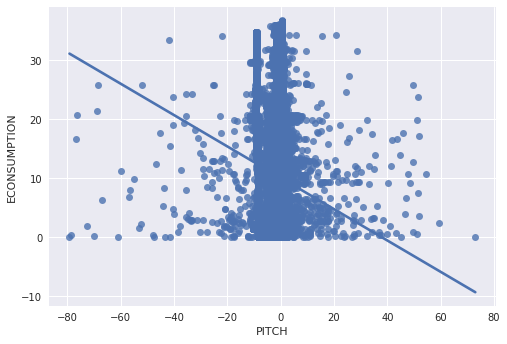

In [7]:
ax = sns.regplot(x="PITCH", y="ECONSUMPTION", ci=None, truncate=True, data=vehicles)

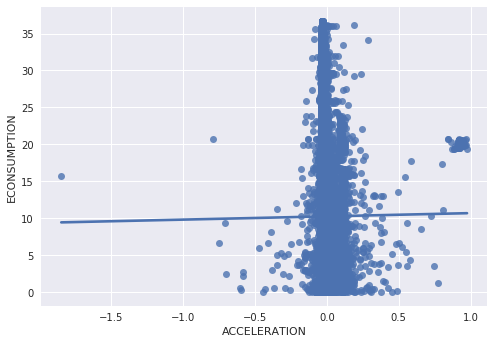

In [8]:
ax = sns.regplot(x="ACCELERATION", y="ECONSUMPTION", ci=None, truncate=True, data=vehicles)

In [9]:
vehicles.describe()

,TIMESTAMP,VOLTAGE_AVG,CURRENT_AVG,ECONSUMPTION,ACCELERATION,SHOCKS,MOTORTEMP,CAPACITY,PITCH,ROLL,YAW
count,1.932460e+05,192555.000000,192555.000000,193246.000000,192408.000000,192599.000000,15175.00000,193246.000000,192409.000000,192408.000000,192408.000000
mean,1.499253e+12,6.126522,211.246046,10.247332,-0.022869,0.001381,28.20286,71.495105,-0.490679,0.021815,11.087114
std,4.621490e+09,0.627981,74.652350,7.998370,0.039918,0.037138,2.30947,22.641713,2.155818,5.138120,118.589509
min,1.493136e+12,0.000000,0.000000,0.004000,-1.847000,0.000000,-0.00000,0.000000,-79.180000,-172.520000,-346.160000
25%,1.495194e+12,5.794000,187.020000,3.715000,-0.033000,0.000000,26.90000,58.000000,-0.560000,-0.590000,-34.850000
50%,1.499096e+12,6.132000,196.179990,8.357000,-0.029000,0.000000,28.20000,77.000000,-0.080000,-0.050000,0.800000
75%,1.499858e+12,6.495000,206.960010,15.364000,-0.017000,0.000000,29.40000,90.000000,0.280000,0.360000,84.470000
max,1.511529e+12,11.977000,1628.699950,36.762000,0.975000,1.000000,34.40000,99.000000,72.990000,359.310000,342.390000


<h2> Preprocessing </h2>

The goal is predict ECONSUMPTION with ACCELERATION, PITCH, ROLL and YAW.

We need to some clean-up of the data:
<ol>
<li>Get ride of all lines without ECONSUMPTION</li>
<li>Get ride of all lines without ACCELERATION</li>
<li>Get ride of all lines without PITCH</li>
<li>Get ride of all lines without ROLL</li>
<li>Get ride of all lines without YAW</li>
<li>Normalize ACCELERATION, PITCH, ROLL and YAW</li>
</ol>

In [10]:
# run a dataprep receipe
# reload data to big Query

In [11]:
%sql --module letslookatthedatapre
SELECT
  ACCELERATION,
  ECONSUMPTION,
  PITCH,
  ROLL,
  YAW
FROM
  [go-de-internal:democases_go_reply_internal.vehicle_heath_status_preprocessed]
WHERE
  ECONSUMPTION > 0 AND 
  ACCELERATION < 1 AND PITCH < 1 AND ROLL < 1 AND YAW < 1 AND
  ACCELERATION > -1 AND PITCH > -1 AND ROLL > -1 AND YAW > -1

In [12]:
vehicles = bq.Query(letslookatthedatapre, EVERY_N=1).to_dataframe()
vehicles[:10]

,ACCELERATION,ECONSUMPTION,PITCH,ROLL,YAW
0,0.0210,10.167,-0.017111,-0.022333,0.653722
1,-0.0115,5.016,-0.001556,-0.001167,0.002278
2,0.0560,2.693,-0.005111,-0.005389,0.096722
3,-0.0215,5.513,-0.046167,0.001889,0.903500
4,0.0455,4.477,0.014333,0.011056,-0.224778
5,-0.0130,7.431,0.004500,-0.017833,0.850722
6,-0.0040,2.541,0.013056,-0.061444,-0.861444
7,0.0470,12.162,0.000444,-0.000778,0.023556
8,-0.0025,3.417,-0.004111,-0.005111,0.113333
9,-0.0215,13.768,0.001222,-0.001222,-0.503000


In [13]:
vehicles.describe()

,ACCELERATION,ECONSUMPTION,PITCH,ROLL,YAW
count,167276.000000,167276.000000,167276.000000,167276.000000,167276.000000
mean,-0.011601,10.267128,-0.002614,-0.000226,0.087775
std,0.020561,8.022834,0.011900,0.010238,0.424636
min,-0.923500,0.004000,-0.437278,-0.958444,-0.999278
25%,-0.016500,3.637000,-0.002667,-0.002944,-0.083250
50%,-0.014500,8.362000,-0.000389,-0.000167,0.004833
75%,-0.008500,15.591000,0.001667,0.001889,0.376389
max,0.487500,36.762000,0.405500,0.857833,0.999944


<h1> Preparation for ML Regression </h1>

Two things: we need to separate the data to test the model and we need to run the data with a basic regression to create a baseline.

In [14]:
shuffled = vehicles.sample(frac=1)
trainsize = int(len(shuffled['ECONSUMPTION']) * 0.70)
validsize = int(len(shuffled['ECONSUMPTION']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

In [15]:
df_train.describe()

,ACCELERATION,ECONSUMPTION,PITCH,ROLL,YAW
count,117093.000000,117093.000000,117093.000000,117093.000000,117093.000000
mean,-0.011610,10.292586,-0.002635,-0.000244,0.088531
std,0.020397,8.045085,0.011838,0.010557,0.425267
min,-0.923500,0.005000,-0.437278,-0.958444,-0.998167
25%,-0.016500,3.648000,-0.002667,-0.003000,-0.083778
50%,-0.014500,8.366000,-0.000389,-0.000167,0.004944
75%,-0.008500,15.638000,0.001667,0.001889,0.377667
max,0.487500,36.755000,0.405500,0.778556,0.999944


In [16]:
df_valid.describe()

,ACCELERATION,ECONSUMPTION,PITCH,ROLL,YAW
count,25091.000000,25091.000000,25091.000000,25091.000000,25091.000000
mean,-0.011389,10.217105,-0.002542,-0.000266,0.086040
std,0.022549,7.985876,0.011229,0.008263,0.425012
min,-0.394500,0.005000,-0.389722,-0.126389,-0.969056
25%,-0.016500,3.603000,-0.002556,-0.002944,-0.082333
50%,-0.014000,8.363000,-0.000333,-0.000167,0.004611
75%,-0.008500,15.480000,0.001667,0.001889,0.373389
max,0.469000,36.762000,0.254833,0.284333,0.999778


In [17]:
df_test.describe()

,ACCELERATION,ECONSUMPTION,PITCH,ROLL,YAW
count,25092.000000,25092.000000,25092.000000,25092.000000,25092.000000
mean,-0.011767,10.198349,-0.002591,-0.000104,0.085986
std,0.019191,7.955116,0.012806,0.010508,0.421304
min,-0.376000,0.004000,-0.382222,-0.134944,-0.999278
25%,-0.016500,3.632750,-0.002667,-0.002889,-0.082181
50%,-0.014500,8.341000,-0.000389,-0.000111,0.004833
75%,-0.008500,15.474750,0.001611,0.001944,0.365556
max,0.484000,36.702000,0.329722,0.857833,0.999944


Let's write out the three dataframes to appropriately named csv files. If we want to run this again, we can simply read those .csv files in and don't need to run the query again.

In [18]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('ECONSUMPTION')
  cols.insert(0, 'ECONSUMPTION')
  print (cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)

to_csv(df_train, 'vehicles-train.csv')
to_csv(df_valid, 'vehicles-valid.csv')
to_csv(df_test, 'vehicles-test.csv')

['ECONSUMPTION', u'ACCELERATION', u'PITCH', u'ROLL', u'YAW', 'key']
['ECONSUMPTION', u'ACCELERATION', u'PITCH', u'ROLL', u'YAW', 'key']
['ECONSUMPTION', u'ACCELERATION', u'PITCH', u'ROLL', u'YAW', 'key']


In [19]:
!ls -l *.csv

-rw-r--r-- 1 root root 2003173 Feb 26 15:34 vehicles-test.csv
-rw-r--r-- 1 root root 9398073 Feb 26 15:34 vehicles-train.csv
-rw-r--r-- 1 root root 2001876 Feb 26 15:34 vehicles-valid.csv


In [20]:
!head -10 vehicles-train.csv

2.743,-0.014,-0.0027222222222222222,0.0008333333333333333,0.005333333333333333,0
0.581,-0.0085,0.0003888888888888889,0.0005,0.001611111111111111,1
20.649,-0.009,0.0012222222222222222,-0.0003333333333333333,0.8818888888888889,2
4.445,-0.0065,0.0003888888888888889,-0.004111111111111111,-0.9246111111111112,3
29.763,-0.0175,0.0029444444444444444,-0.00011111111111111112,0.37977777777777777,4
8.086,-0.016,0.0009444444444444445,-0.004833333333333334,0.007277777777777778,5
23.025,-0.0025,-0.0016666666666666666,0.0054444444444444445,0.5029444444444444,6
0.991,-0.0145,-0.0012777777777777779,-0.010277777777777778,0.7038888888888889,7
4.278,-0.0135,-0.0007777777777777778,-0.010555555555555556,0.0002777777777777778,8
7.001,-0.0105,0.0002777777777777778,0.0011111111111111111,-0.026,9


In [21]:
!head -10 vehicles-valid.csv

21.308,-0.0155,-0.0007777777777777778,-0.007222222222222223,0.4809444444444444,0
3.961,-0.016,-0.009722222222222222,0.0061666666666666675,0.22594444444444445,1
19.976,-0.016,0.0045000000000000005,-0.0024444444444444444,0.3095,2
3.198,-0.016,0.007555555555555556,0.0027222222222222222,-0.09377777777777777,3
12.472,-0.0235,0.0006111111111111111,0.0003333333333333333,-0.014666666666666668,4
2.244,-0.0085,-0.0013333333333333333,-0.0008333333333333333,0.8643333333333334,5
18.745,-0.022,-0.0010555555555555557,-0.006055555555555556,-0.06838888888888889,6
1.727,-0.0105,0.001888888888888889,-0.0003888888888888889,-0.3111111111111111,7
6.399,-0.0185,0.0031111111111111114,-0.0022777777777777774,0.07216666666666667,8
3.04,-0.014,-0.00022222222222222223,5.555555555555556e-05,0.004277777777777778,9


In [22]:
!head -10 vehicles-test.csv

23.226,-0.0165,-0.003333333333333333,-0.0011666666666666665,-0.5652222222222222,0
12.774,-0.01,-0.0009444444444444445,0.0021666666666666666,0.34894444444444445,1
15.473,-0.0175,-0.02266666666666667,0.005111111111111111,0.5559444444444444,2
28.657,-0.0175,-0.049722222222222216,-0.001388888888888889,0.5563333333333333,3
16.969,-0.014,0.0045000000000000005,-0.00044444444444444447,-0.09672222222222222,4
1.769,-0.0085,0.0011111111111111111,0.0007222222222222223,-0.013777777777777778,5
5.918,-0.0085,0.0020555555555555557,0.0011666666666666665,0.030555555555555555,6
15.011,-0.0105,0.0036111111111111114,-0.0022222222222222222,-0.4166666666666667,7
8.17,-0.0145,0.0022222222222222222,0.0013333333333333333,-0.19355555555555556,8
24.053,-0.014,-0.0025,-0.0034444444444444444,0.1825,9


create the baseline model and compute its RSME

In [23]:
import datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

def estimate_stress(df):
  columns = [abs(df['ACCELERATION']), abs(df['PITCH']), abs(df['ROLL']), abs(df['YAW'])]
  stress_level = sum(columns)/4
  return stress_level

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, econsump, name):
  print ("{1} RMSE = {0}".format(compute_rmse(df['ECONSUMPTION'], econsump*estimate_stress(df)), name))

FEATURES = ['ACCELERATION', 'PITCH','ROLL','YAW']
TARGET = 'ECONSUMPTION'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('vehicles-train.csv', header=None, names=columns)
df_valid = pd.read_csv('vehicles-valid.csv', header=None, names=columns)
df_test = pd.read_csv('vehicles-test.csv', header=None, names=columns)
econsump = df_train['ECONSUMPTION'].mean() * estimate_stress(df_train).mean()/4
print ("averageEconsumption = ", econsump)
print_rmse(df_train, econsump, 'Train')
print_rmse(df_valid, econsump, 'Valid')
print_rmse(df_test, econsump, 'Test')

('averageEconsumption = ', 0.21819148726949508)
Train RMSE = 13.0462297366
Valid RMSE = 12.9503168446
Test RMSE = 12.9168039067


<h1> ML Regression with Neural Network </h1>

Now lets try and run a smarter model.

In [24]:
import tensorflow as tf
print tf.__version__

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.5.0


In [25]:
import os
PROJECT = 'go-de-internal'
BUCKET = 'storage-democases-go-reply-internal'
REGION = 'us-central1'
REPO = "/content/datalab/democases-go-reply-internal/vehicle-health-status"
os.listdir(REPO)

['vehicles-train.csv',
 '.ipynb_checkpoints',
 'vehicles-valid.csv',
 'econsumption',
 'test.json',
 'hyperparam.yaml',
 'vehicles-test.csv',
 ' regression-with-neural-networks.ipynb']

In [26]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['REPO'] = REPO

In [27]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [28]:
%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print response['serviceAccount']")

echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Authorizing the Cloud ML Service account service-462605511119@cloud-ml.google.com.iam.gserviceaccount.com to access files in storage-democases-go-reply-internal


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133    0   133    0     0    532      0 --:--:-- --:--:-- --:--:--   534
No changes to gs://storage-democases-go-reply-internal/
No changes to gs://storage-democases-go-reply-internal/churn_cloud/churn-test.csv
No changes to gs://storage-democases-go-reply-internal/churn_cloud/churn-train.csv
No changes to gs://storage-democases-go-reply-internal/churn_cloud/churn-valid.csv
No changes to gs://storage-democases-go-reply-internal/churn_cloud/churn_time_dependent_sorted.csv
No changes to gs://storage-democases-go-reply-internal/churn_cloud/churn_time_dependent_unsorted.csv
No changes to gs://storage-democases-go-reply-internal/churn_with_neural_net/churn-test.csv
No changes to gs://storage-democases-go-reply-internal/churn_with_neural_net/churn-train.csv
No changes to gs://storage-democases-go-reply-internal/churn_with_neural_n

In [29]:
!cat econsumption/trainer/model.py

In [30]:
%bash
head -1 $REPO/vehicles-train.csv
head -1 $REPO/vehicles-valid.csv

2.743,-0.014,-0.0027222222222222222,0.0008333333333333333,0.005333333333333333,0
21.308,-0.0155,-0.0007777777777777778,-0.007222222222222223,0.4809444444444444,0


<h2> Running the Python module from the command-line </h2>

In [31]:
%bash
rm -rf vehicles.tar.gz vehicles_trained
export PYTHONPATH=${PYTHONPATH}:${REPO}/econsumption
python -m trainer.task \
   --train_data_paths="${REPO}/vehicles-train*" \
   --eval_data_paths=${REPO}/vehicles-valid.csv  \
   --output_dir=${REPO}/vehicles_trained \
   --num_epochs=10 --job-dir=./tmp

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fca2dd10250>, '_model_dir': '/content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles_trained/', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_mem

In [32]:
!ls $REPO/vehicles_trained/export/Servo

1519659332


In [33]:
%writefile ./test.json
{"ACCELERATION": 0.3424933,"PITCH": 0.4929889823,"ROLL": 0.999398298932,"YAW": 0.103000023}

Overwriting ./test.json


In [34]:
%bash
model_dir=$(ls ${REPO}/vehicles_trained/export/Servo)
gcloud ml-engine local predict \
    --model-dir=${REPO}/vehilces_trained/export/Servo/${model_dir} \
    --json-instances=./test.json

ERROR: (gcloud.ml-engine.local.predict) /usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Traceback (most recent call last):
  File "lib/googlecloudsdk/command_lib/ml_engine/local_predict.py", line 111, in <module>
    main()
  File "lib/googlecloudsdk/command_lib/ml_engine/local_predict.py", line 106, in main
    instances=instances)
  File "/tools/google-cloud-sdk/lib/third_party/cloud_ml_engine_sdk/prediction/prediction_lib.py", line 1304, in local_predict
    client = create_client(framework, model_dir, tags)
  File "/tools/google-cloud-sdk/lib/third_party/cloud_ml_engine_sdk/prediction/prediction_lib.py", line 1242, in create_client
    return create_client_fn(model_path, tags)
  File "/tools/google-cloud-sdk/lib/third_

<h2> Running locally using gcloud </h2>

In [35]:
%bash
rm -rf vehicles.tar.gz vehicles_trained
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${REPO}/churn-with-neural-net/trainer \
   -- \
   --train_data_paths=${REPO}/vehicles-train.csv \
   --eval_data_paths=${REPO}/vehicles-valid.csv  \
   --num_epochs=10 \
   --output_dir=${REPO}/vehicles_trained 

ERROR: (gcloud.ml-engine.local.train) /usr/local/envs/py2env/bin/python: command not found


In [36]:
from google.datalab.ml import TensorBoard
TensorBoard().start('{}/vehicles_trained'.format(REPO))

TensorBoard was started successfully with pid 20213. Click here to access it.

20213

In [37]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print 'Stopped TensorBoard with pid {}'.format(pid)

Stopped TensorBoard with pid 20213


In [38]:
!ls $REPO/vehicles_trained

ls: cannot access '/content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles_trained': No such file or directory


<h2> Submit training job using gcloud </h2>

First copy the training data to the cloud.  Then, launch a training job.

In [39]:
%bash
echo $BUCKET
gsutil -m rm -rf gs://${BUCKET}/econsumption/smallinput/
gsutil -m cp ${REPO}/*.csv gs://${BUCKET}/econsumption/smallinput/

storage-democases-go-reply-internal


Removing gs://storage-democases-go-reply-internal/econsumption/smallinput/vehicles-test.csv#1518550242684819...
Removing gs://storage-democases-go-reply-internal/econsumption/smallinput/vehicles-train.csv#1518550242751180...
Removing gs://storage-democases-go-reply-internal/econsumption/smallinput/vehicles-valid.csv#1518550242649775...
/ [3/3 objects] 100% Done                                                       
Operation completed over 3 objects.                                              
Copying file:///content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles-test.csv [Content-Type=text/csv]...
Copying file:///content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles-train.csv [Content-Type=text/csv]...
Copying file:///content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles-valid.csv [Content-Type=text/csv]...
/ [3/3 files][ 12.8 MiB/ 12.8 MiB] 100% Done                                    
Operation completed over 3 objects/

In [40]:
%%bash
OUTDIR=gs://${BUCKET}/econsumption/smallinput/vehicles_trained
JOBNAME=vehicles_health_demo_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${REPO}/econsumption/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.0 \
   -- \
   --train_data_paths="gs://${BUCKET}/econsumption/smallinput/vehicles-train*" \
   --eval_data_paths="gs://${BUCKET}/econsumption/smallinput/vehicles-valid*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100

gs://storage-democases-go-reply-internal/econsumption/smallinput/vehicles_trained us-central1 vehicles_health_demo_180226_153547
jobId: vehicles_health_demo_180226_153547
state: QUEUED


CommandException: 1 files/objects could not be removed.
/tools/google-cloud-sdk/lib/googlecloudsdk/core/util/files.py:622: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  for chunk in iter(lambda: fp.read(4096), ''):
Job [vehicles_health_demo_180226_153547] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe vehicles_health_demo_180226_153547

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs vehicles_health_demo_180226_153547


<h1> Deploy model </h1>

Find out the actual name of the subdirectory where the model is stored and use it to deploy the model.

In [41]:
%bash
gsutil ls gs://${BUCKET}/econsumption/smallinput/vehicles_trained/export/Servo

CommandException: One or more URLs matched no objects.


In [42]:
%bash
MODEL_NAME="econsumption"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/econsumption/smallinput/vehicles_trained/export/Servo | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION}

Deleting and deploying econsumption v1 from  ... this will take a few minutes


CommandException: One or more URLs matched no objects.
Created ml engine model [projects/go-de-internal/models/econsumption].
ERROR: (gcloud.ml-engine.versions.create) argument --origin: expected one argument
Usage: gcloud ml-engine versions create VERSION --model=MODEL [optional flags]
  optional flags may be  --async | --config | --description | --help |
                         --labels | --origin | --runtime-version |
                         --staging-bucket

For detailed information on this command and its flags, run:
  gcloud ml-engine versions create --help


<h1> Prediction </h1>

In [43]:
%bash
gcloud ml-engine predict --model=econsumption --version=v1 --json-instances=./test.json

ERROR: (gcloud.ml-engine.predict) HTTP request failed. Response: {
  "error": {
    "code": 404,
    "message": "Field: name Error: The specified model version was not found.",
    "status": "NOT_FOUND",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.BadRequest",
        "fieldViolations": [
          {
            "field": "name",
            "description": "The specified model version was not found."
          }
        ]
      }
    ]
  }
}



In [44]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

request_data = {'instances':
  [
      {
        'ACCELERATION': 0.3424933,
        'PITCH': 0.49298898232,
        'ROLL': 0.999398298932,
        'YAW': 0.103000023,
      }
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'econsumption', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print "response={0}".format(response)

HttpError: <HttpError 404 when requesting https://ml.googleapis.com/v1/projects/go-de-internal/models/econsumption/versions/v1:predict?alt=json returned "Field: name Error: The specified model version was not found.">

<h1> Create hyper-parameter tuning </h1>

The file specifies the search region in parameter space.  Cloud MLE carries out a smart search algorithm within these constraints (i.e. it does not try out every single value).

In [45]:
!grep -A 2 add_argument econsumption/trainer/task.py




--



--



--



--



--



--



--



--



--



--



--



--





In [46]:
!grep -A 5 eval_metric econsumption/trainer/model.py

In [47]:
%writefile hyperparam.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    goal: MINIMIZE
    maxTrials: 30
    maxParallelTrials: 1
    params:
    - parameterName: train_batch_size
      type: INTEGER
      minValue: 64
      maxValue: 512
      scaleType: UNIT_LOG_SCALE
    - parameterName: nbuckets
      type: INTEGER
      minValue: 10
      maxValue: 20
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: hidden_units
      type: CATEGORICAL
      categoricalValues: ["128 32", "256 128 16", "64 64 64 8"]       

Overwriting hyperparam.yaml


In [48]:
%bash
echo $BUCKET
gsutil -m rm -rf gs://${BUCKET}/econsumption/hyper_param/
gsutil -m cp ${REPO}/*.csv gs://${BUCKET}/econsumption/hyper_param/

storage-democases-go-reply-internal


Removing gs://storage-democases-go-reply-internal/econsumption/hyper_param/vehicles-test.csv#1518609980764351...
Removing gs://storage-democases-go-reply-internal/econsumption/hyper_param/vehicles-train.csv#1518609981046012...
Removing gs://storage-democases-go-reply-internal/econsumption/hyper_param/vehicles-valid.csv#1518609980758452...
/ [3/3 objects] 100% Done                                                       
Operation completed over 3 objects.                                              
Copying file:///content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles-test.csv [Content-Type=text/csv]...
Copying file:///content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles-train.csv [Content-Type=text/csv]...
Copying file:///content/datalab/democases-go-reply-internal/vehicle-health-status/vehicles-valid.csv [Content-Type=text/csv]...
/ [3/3 files][ 12.8 MiB/ 12.8 MiB] 100% Done                                    
Operation completed over 3 objec

In [49]:
%%bash
OUTDIR=gs://${BUCKET}/econsumption/hyper_param/vehicles_trained
JOBNAME=vehicles_health_demo_hyper_param_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${REPO}/econsumption/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=STANDARD_1 \
   --runtime-version=1.2 \
   --config=hyperparam.yaml \
   -- \
   --train_data_paths="gs://$BUCKET/econsumption/hyper_param/vehicles-train*" \
   --eval_data_paths="gs://${BUCKET}/econsumption/hyper_param/vehicles-valid*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100

gs://storage-democases-go-reply-internal/econsumption/hyper_param/vehicles_trained us-central1 vehicles_health_demo_hyper_param_180226_153810
jobId: vehicles_health_demo_hyper_param_180226_153810
state: QUEUED


CommandException: 1 files/objects could not be removed.
/tools/google-cloud-sdk/lib/googlecloudsdk/core/util/files.py:622: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  for chunk in iter(lambda: fp.read(4096), ''):
Job [vehicles_health_demo_hyper_param_180226_153810] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe vehicles_health_demo_hyper_param_180226_153810

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs vehicles_health_demo_hyper_param_180226_153810
